# Daria Bromot - FS500047

## Dimensionality Reduction and Clustering on MNIST

In this exercise, we will work with methods for dimensionality reduction, clustering and machine learning for classification.  

We will start with the MNIST dataset, that includes images of 28x28 pixels of different digits, along with their true labels. Although the dataset is labeled, we will also use it to play with methods of unsupevised and semi-supervised learning.

First, let's import relevant packages and load the MNIST dataset.

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn import metrics
from sklearn.metrics import homogeneity_score, completeness_score
from sklearn.metrics import classification_report
from sklearn.metrics import mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import hdbscan

plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["figure.figsize"] = (20,12)

np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
dim = int(np.sqrt(len(mnist.data.columns))) # 28
X = mnist.data.values # data is pd.DataFrame
y = mnist.target.cat.codes.values # mnist.target is pd.Categorical

In [4]:
print(X.shape)
print(y.shape)
print(dim)

(70000, 784)
(70000,)
28


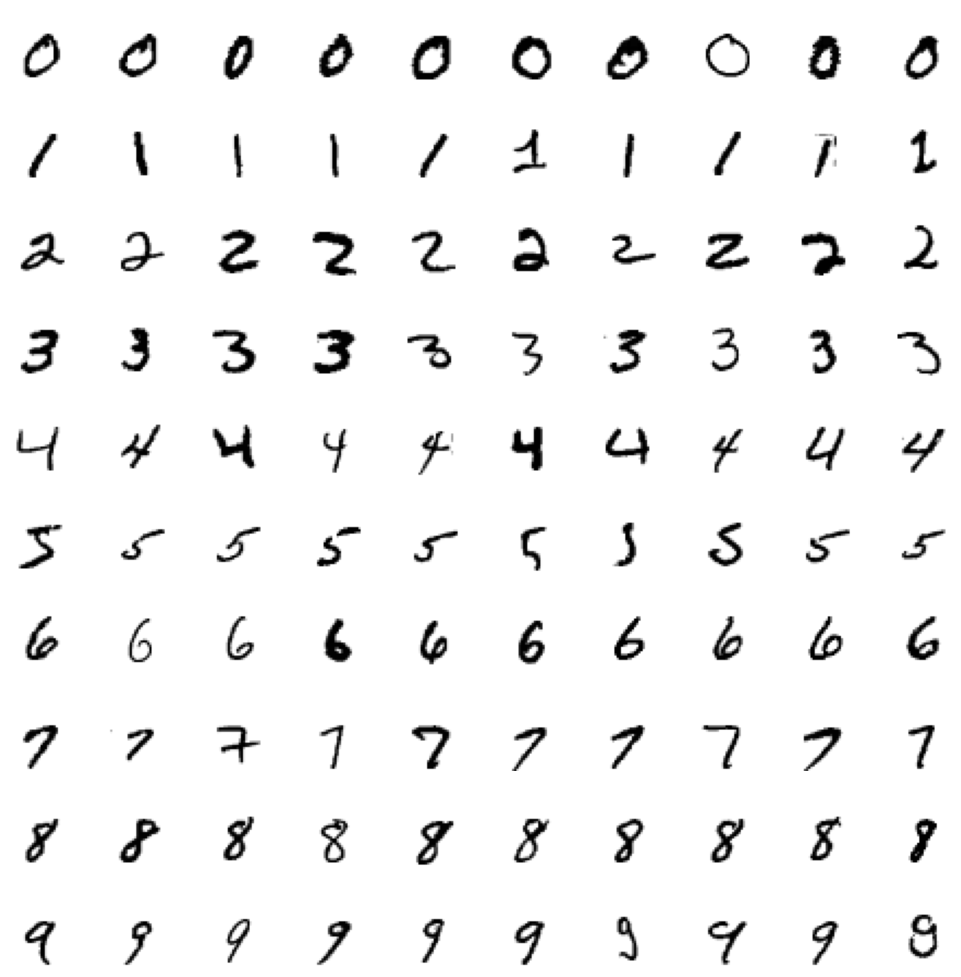

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10)) 
fig.subplots_adjust(hspace=0.1, wspace=0.1)

digit_counts = [0] * 10  

for digit in range(10):
    count = 0 
    
    while count < 10:
        digit_index = np.where(y == digit)[0][digit_counts[digit]]
        digit_image = X[digit_index].reshape((dim, dim))
        
        ax = axes[digit, count]
        ax.imshow(digit_image, cmap='gray_r') 
        ax.axis('off')
        ax.set_title(f"Digit: {digit}", fontsize=8, color='white') 
        ax.set_facecolor('white')  
        
        digit_counts[digit] += 1
        count += 1

plt.tight_layout()
plt.show()

On the first sign, I think we have a huge problem with number 1 and 7, it looks much similar

Use seaborn to plot the number of observations of each class.

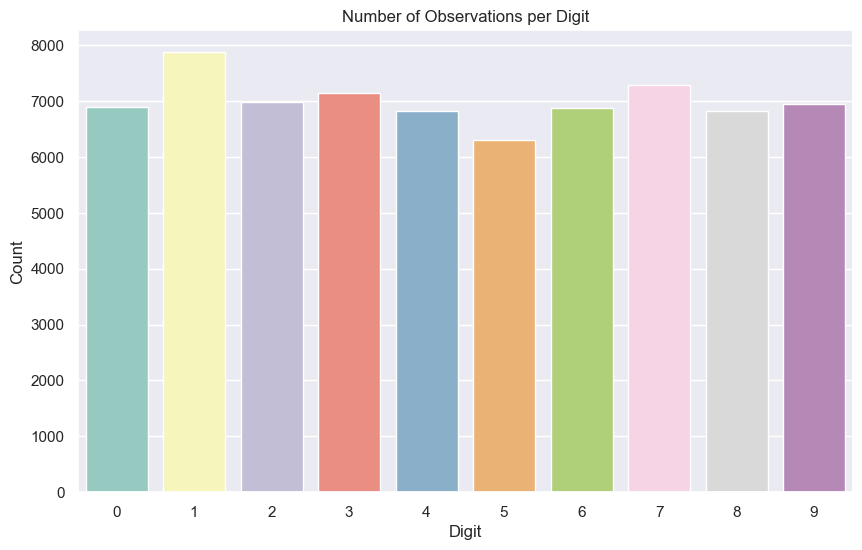

In [6]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(x=y, palette="Set3")

plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Number of Observations per Digit")

plt.show()

To speed things up, let's use a subset of the data, with 5,000 random points.

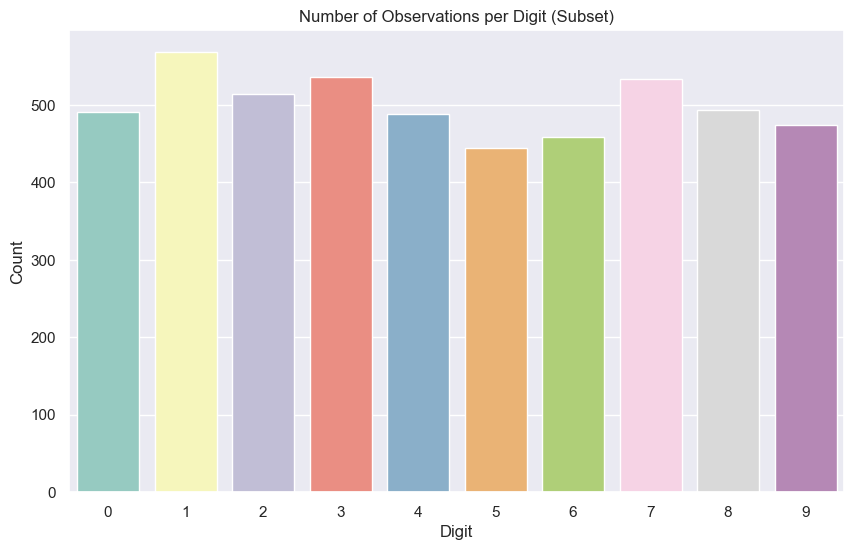

In [74]:
subset_size = 5000 

subset_indices = np.random.choice(len(X), size=subset_size, replace=False) 

subset_X = X[subset_indices]
subset_y = y[subset_indices]

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(x=subset_y, palette="Set3")

plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Number of Observations per Digit (Subset)")

plt.show()

Now, let's split the data into train and test sets.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(subset_X, subset_y, test_size=0.2, random_state=0)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4000, 784)
Test set shape: (1000, 784)


### Dimensionality Reduction using PCA
Reduce dimensions using PCA to 2D.


First, let's use PCA to reduce the dimensions to 50. Plot the percent of explained variance as a function of the number of eigenvectors in PCA.

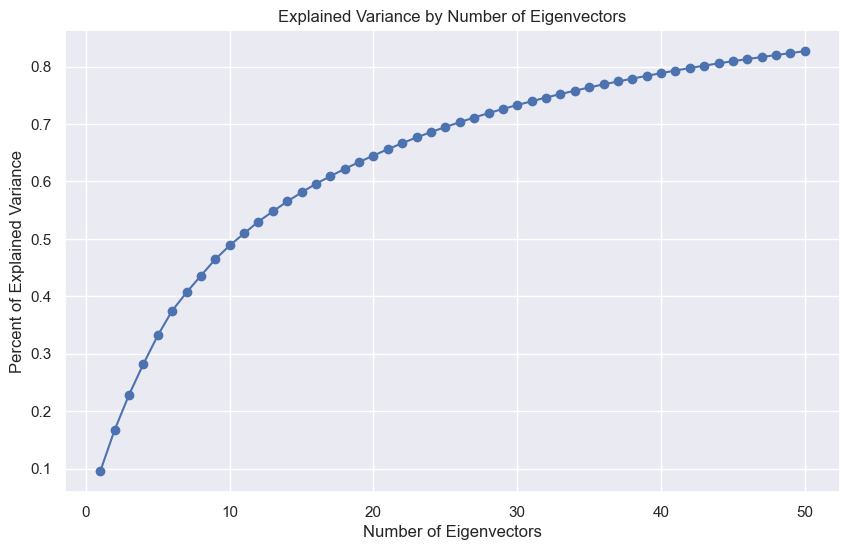

In [9]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_train)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Percent of Explained Variance')
plt.title('Explained Variance by Number of Eigenvectors')
plt.grid(True)
plt.show()

Plot the transformed coordinates of the two largest eigenvectors (i.e. the results of using PCA to reduce dimensions to 2D), with the color of each point representing its digit.

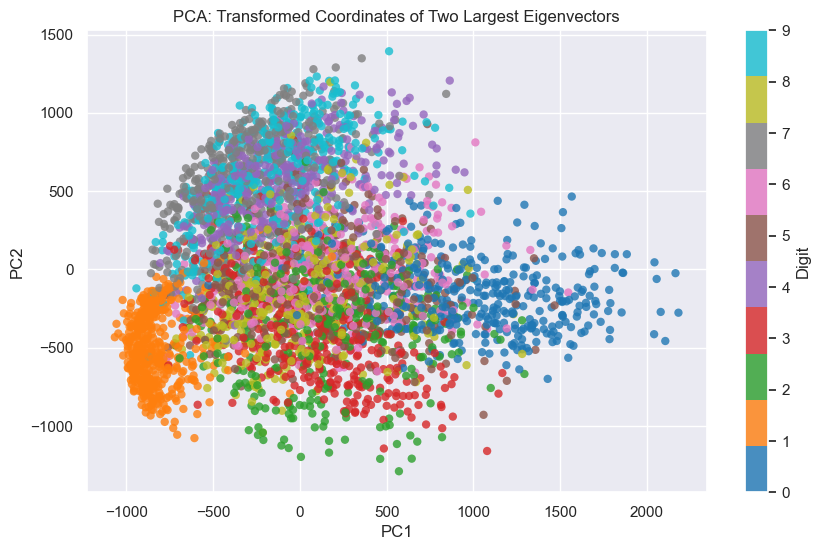

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', edgecolor='none', alpha=0.8)
plt.colorbar(label='Digit')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Transformed Coordinates of Two Largest Eigenvectors')
plt.grid(True)
plt.show()

The visualization of the transformed coordinates in a scatter plot with color-coded digit labels provides a visual representation of how the different digits are distributed in the reduced 2D space. It allows us to observe patterns, clusters, or separability between the digits. 

PC1 and PC2 refer to the first and second principal components obtained through PCA.

Here's a summary of our observations:

1. **Class 0:** we observe separation on one half of the cluster representing digit 0 - it indicates that instances of digit 0 have a distinct sub-grouping within the overall cluster, potentially due to variations or patterns specific to that sub-group.

2. **Class 1:** we observe high density and clear separation, indicating that instances representing digit 1 are clustered together and distinct from other digits.

3. **Classes 2, 3, 6, and 8:** we observe proximity and overlapping between clusters - it indicates that these digits share certain similarities or features, making their instances spatially close and potentially causing confusion or overlap.

4. **Classes 4, 7, and 9:** we notice overlapping between clusters representing - it suggests potential similarities or confusion between these digits, as their instances are spatially close and may share common characteristics.

5. **Class 5:** we notice overlapping of class 5 instances with every other class -  it suggests that digit 5 may have similarities or shared features with other digits, leading to instances being close to and potentially mixed with other clusters.

### Dimensionality Reduction using PCA + tSNE
Next, use PCA to reduce dimensions to 50D, and then use tSNE to further reduce dimensions to 2D. Briefly discuss the results.

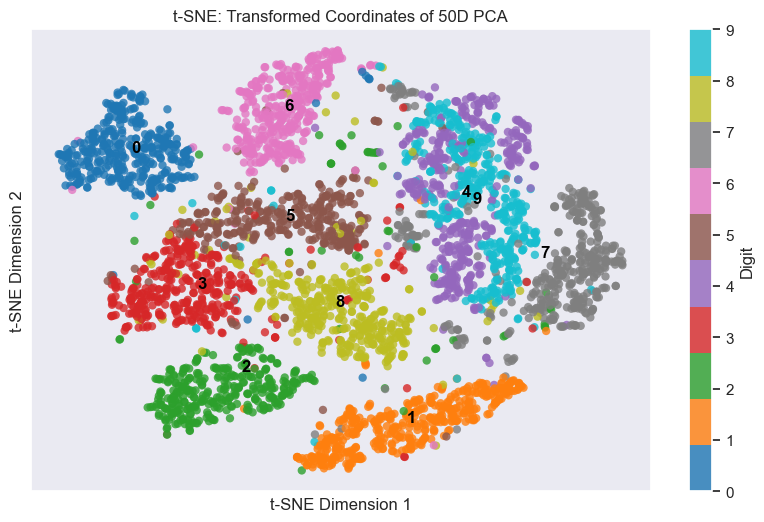

In [11]:
tsne = TSNE(n_components=2, n_iter=500)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='tab10', edgecolor='none', alpha=0.8)
plt.colorbar(label='Digit')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE: Transformed Coordinates of 50D PCA')

plt.xticks([])
plt.yticks([])
for i in range(10):
    plt.text(X_tsne[y_train == i, 0].mean(), X_tsne[y_train == i, 1].mean(), str(i), fontsize=12, color='black', fontweight='bold')

plt.show()

The application of t-SNE on the 50D data results in a 2D scatter plot where each point represents an instance from the dataset.
   - The position of the points in the t-SNE plot is determined based on their similarities in the original high-dimensional space.
   - By observing the t-SNE plot, we can identify clusters, patterns, and separability among different digits.
   - Some clusters - 0, 6, 1 are visually distinct, indicating clear separability between certain digits, while others - 4 and 9 - overlap or show proximity, indicating potential confusion or similarity between digits.

tSNE is notorious for producing very different results in different runs. 

Play with the tSNE parameters and show a few images that demonstrate its robustness or sensitivity to the used parameters.

Finding the optimal combination of parameters for t-SNE:

1. **Perplexity:** Start by trying a range of perplexity values. Lower perplexity values (e.g., 5-30) tend to emphasize local structure, while higher values (e.g., 50-100) focus more on global structure. 

2. **Learning Rate:** The learning rate (`learning_rate`) determines the step size at each iteration of the t-SNE optimization process. The default value of 200 is often suitable.

3. **Number of Iterations:** The number of iterations (`n_iter`) controls the total number of optimization steps performed by t-SNE. The default value of 1,000 is a good starting point.

Let's lower perplexity=5:

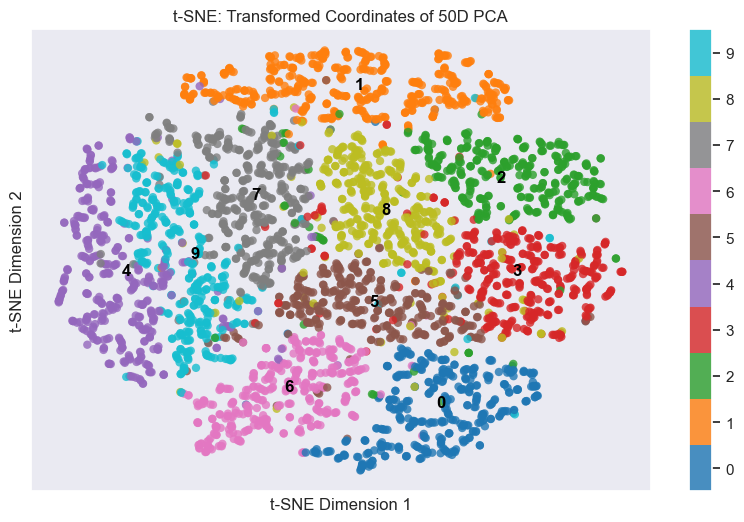

In [12]:
tsne = TSNE(n_components=2, perplexity=5, n_iter=500)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='tab10', edgecolor='none', alpha=0.8)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE: Transformed Coordinates of 50D PCA')

plt.xticks([])
plt.yticks([])
for i in range(10):
    plt.text(X_tsne[y_train == i, 0].mean(), X_tsne[y_train == i, 1].mean(), str(i), fontsize=12, color='black', fontweight='bold')

plt.show()

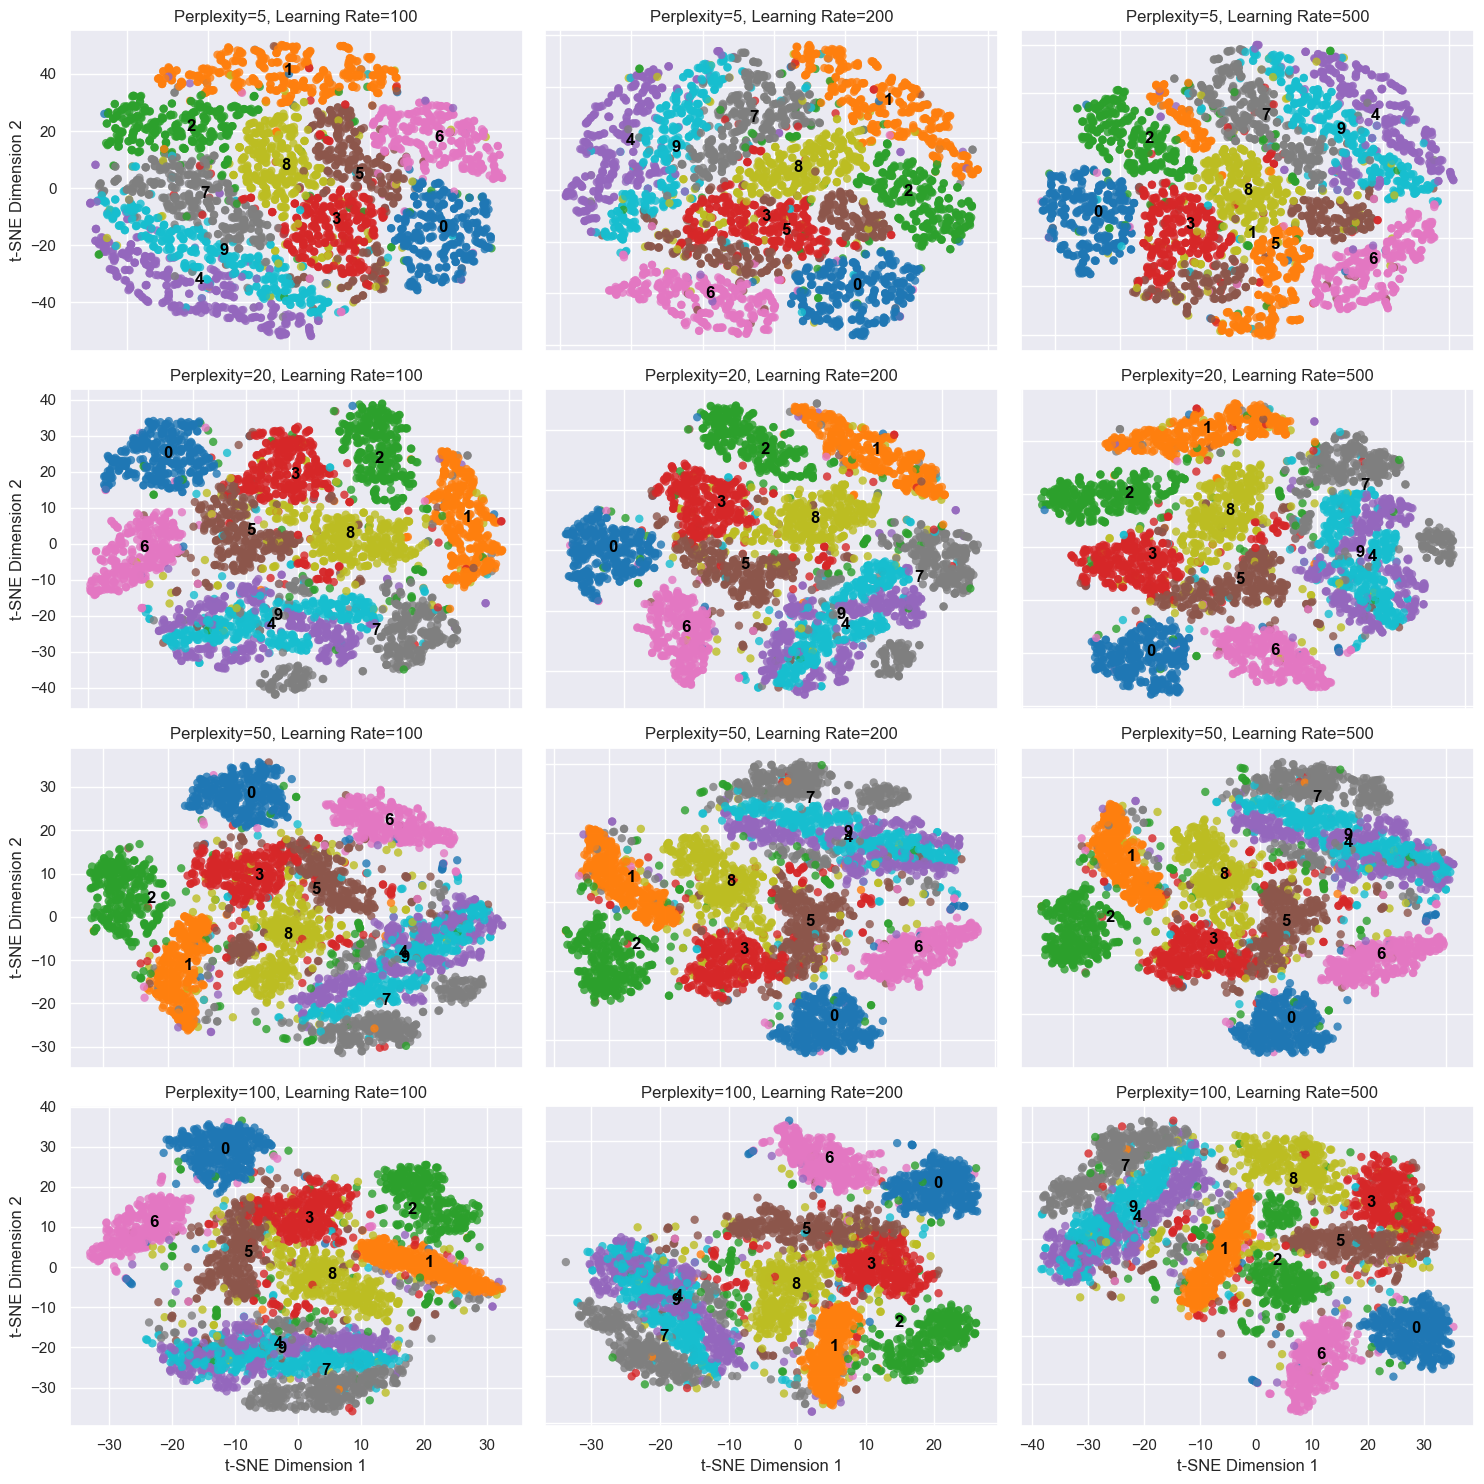

In [13]:
perplexity_values = [5, 20, 50, 100]
learning_rate_values = [100, 200, 500]

fig, axs = plt.subplots(len(perplexity_values), len(learning_rate_values), figsize=(15, 15))

for i, perplexity in enumerate(perplexity_values):
    for j, learning_rate in enumerate(learning_rate_values):
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=500)
        X_tsne = tsne.fit_transform(X_train)
        ax = axs[i, j]
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='tab10', edgecolor='none', alpha=0.8)
        ax.set_xlabel('t-SNE Dimension 1')
        ax.set_ylabel('t-SNE Dimension 2')
        ax.set_title(f"Perplexity={perplexity}, Learning Rate={learning_rate}")
        ax.label_outer()
        for k in range(10):
            ax.text(X_tsne[y_train == k, 0].mean(), X_tsne[y_train == k, 1].mean(), str(k), fontsize=12, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

Plot the Shepard Diagram, giving the distance between points in the original 784D space, in the 50D space after PCA, and in the 2D tSNE space.  

Note that we're going to compute the distance between all pairs of points, so we'll get N^2 points in the Shepard diagram. We can choose a small subset of the points (say, 100 points) and get a good statistical understanding of the behavior.

In [81]:
# Select a subset of points
subset_indices = np.random.choice(len(X_train), size=100, replace=False)

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_train)
tsne = TSNE(n_components=2, n_iter=250)
X_tsne = tsne.fit_transform(X_pca)

distances_tsne = euclidean_distances(X_tsne[subset_indices,:])
distances_pca = euclidean_distances(X_pca[subset_indices,:])
distances_original = euclidean_distances(X_train[subset_indices,:])

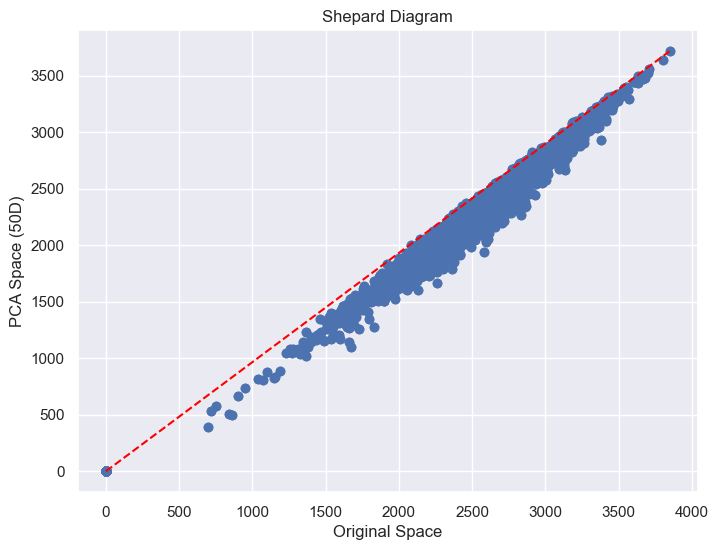

In [77]:
plt.figure(figsize=(8, 6))
plt.scatter(distances_original, distances_pca)
plt.plot([0, np.max(distances_original)], [0, np.max(distances_pca)], color='red', linestyle='--')
plt.xlabel('Original Space')
plt.ylabel('PCA Space (50D)')
plt.title('Shepard Diagram')
plt.show()

Interpreting the Shepard Diagram can help assess the quality of the dimensionality reduction technique 

If the points in the Shepard Diagram closely follow a straight line, it indicates that the distances in the original space are well preserved in the reduced 50D space.

A close alignment with the diagonal line indicates a good preservation of distances, while deviations from the line suggest a loss of information during the dimensionality reduction.

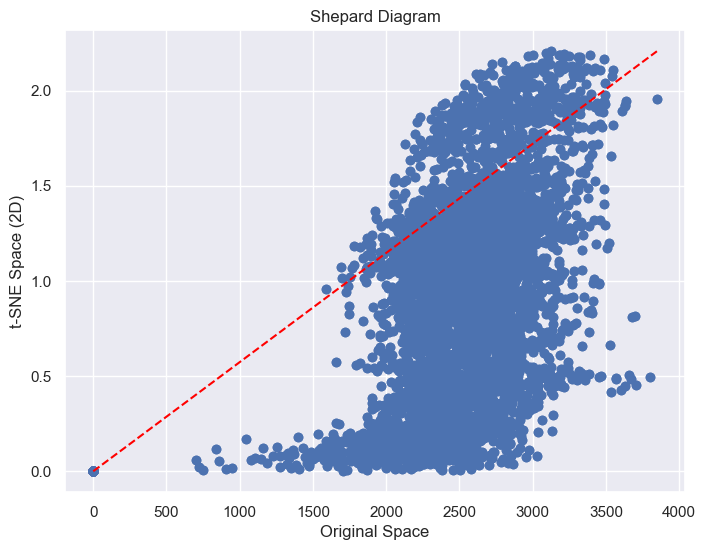

In [78]:
plt.figure(figsize=(8, 6))
plt.scatter(distances_original, distances_tsne)
plt.plot([0, np.max(distances_original)], [0, np.max(distances_tsne)], color='red', linestyle='--')
plt.xlabel('Original Space')
plt.ylabel('t-SNE Space (2D)')
plt.title('Shepard Diagram')
plt.show()

On the other hand, if the points deviate significantly from the line, it suggests that the distances are distorted or not well preserved during the TSNE dimensionality reduction.

### Dimensionality Reduction using UMAP

Use UMAP to reduce the dimensions. First, reduce dimensions to 50D using PCA and then apply UMAP.

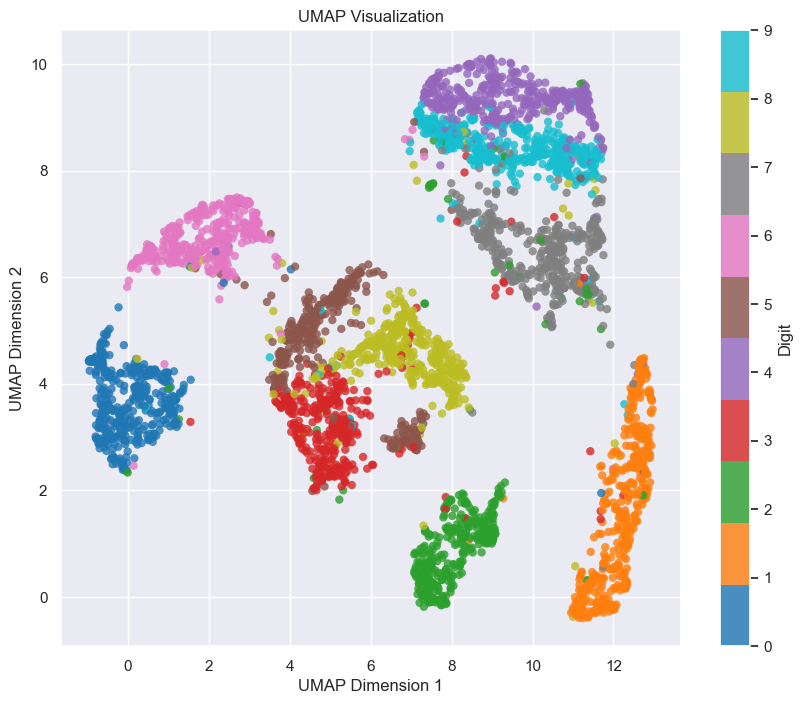

In [83]:
umap_2d = umap.UMAP(n_components=2)
X_umap = umap_2d.fit_transform(X_pca)

plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap='tab10', edgecolor='none', alpha=0.8)
plt.colorbar(label='Digit')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization')
plt.show()

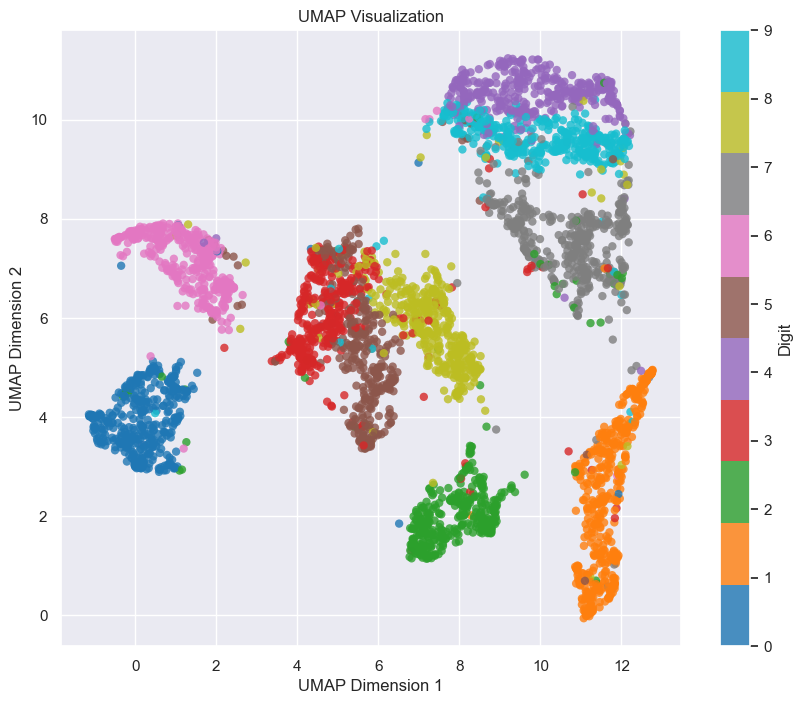

In [84]:
umap_2d = umap.UMAP(n_components=2)
X_umap = umap_2d.fit_transform(X_pca)

# Plot the UMAP results
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap='tab10', edgecolor='none', alpha=0.8)
plt.colorbar(label='Digit')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization')
plt.show()

We can observe potential improves of using UMAP:

1. Improved Non-linear Separation: UMAP captures non-linear relationships in the data. 
2. Preserved Global and Local Structures: PCA captures the global structure of the data by identifying the principal components. By feeding the reduced PCA space into UMAP, we retain this global structure while also preserving local structures. 
3. Reduced Dimensionality.
4. Improved Visualization and Interpretability: UMAP tends to produce embeddings with better clustering and separation properties, making it easier to identify distinct groups or patterns.

**Try apply UMAP for TSNE after PCA:**

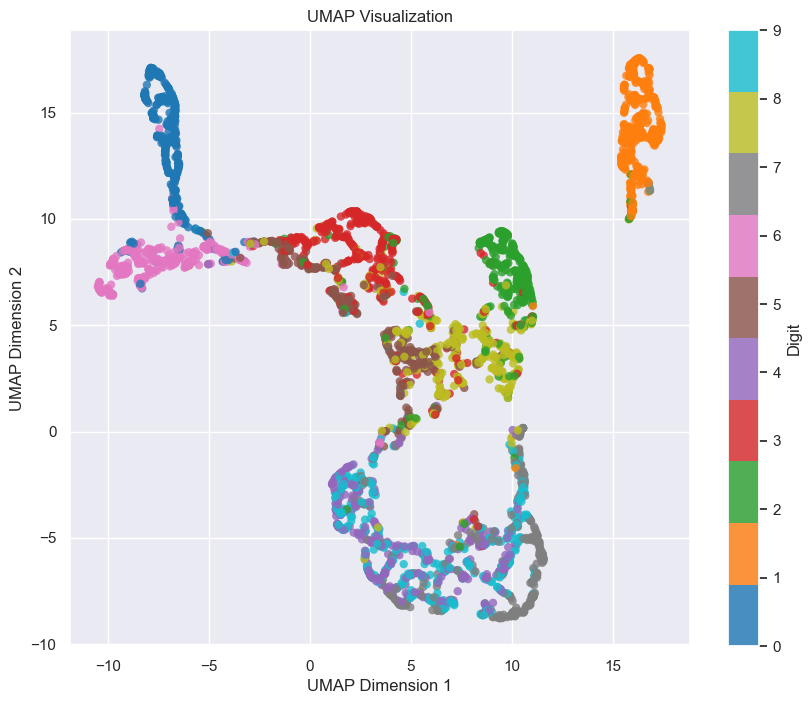

In [85]:
umap_2d = umap.UMAP(n_components=2)
X_umap = umap_2d.fit_transform(X_tsne)

# Plot the UMAP results
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap='tab10', edgecolor='none', alpha=0.8)
plt.colorbar(label='Digit')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization')
plt.show()

### Clustering
Run k-means clustering with k=10 on the 2D space after using PCA to reduce to 50 dimensions and UMAP to 2D.  
Show the contingency table between the identified clusters and the true labels.

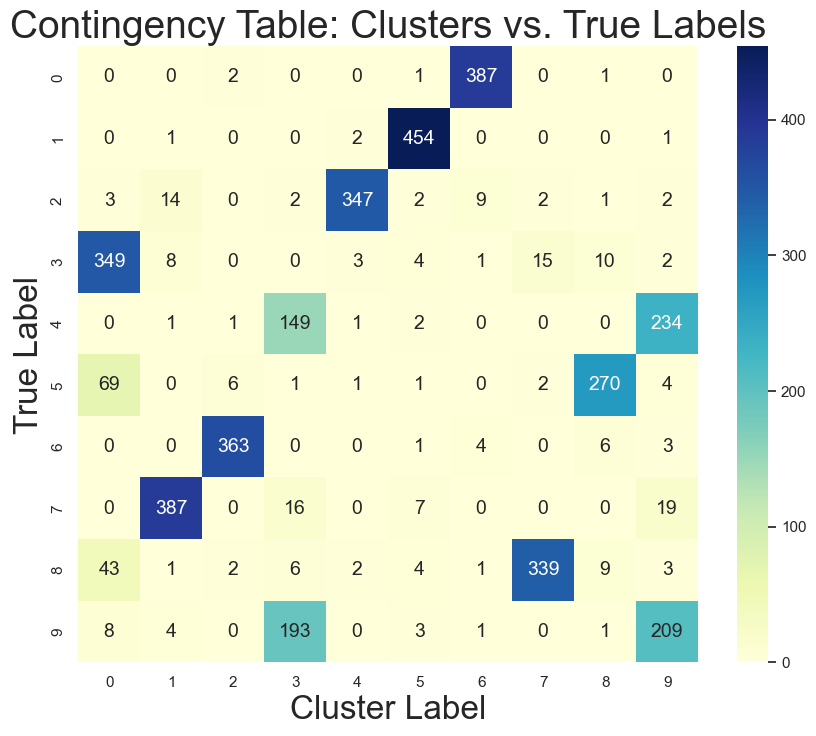

In [96]:
umap_2d = umap.UMAP(n_components=2)
X_umap = umap_2d.fit_transform(X_pca)

kmeans = KMeans(n_clusters=10, random_state=0)
cluster_labels = kmeans.fit_predict(X_umap)

contingency_table = contingency_matrix(y_train, cluster_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Cluster Label")
plt.ylabel("True Label")
plt.title("Contingency Table: Clusters vs. True Labels")
plt.show()

Let's break down the interpretation of the table:

- **The number 0** is frequently misrecognized as 6, with a count of 387 instances 
- **1** has a count of 454 instances in 5.
- **2** is predominantly associated with 4, with a count of 347 instances.
- **3** is most commonly found in 0, with a count of 349 instances.
- **4** is often mistaken for 9, with counts of 234 instances in 9 and 149 instances in 3.
- **5** is primarily associated with 8, with a count of 270 instances, followed by 69 instances in 0.
- **6** has a significant presence in 2, with a count of 363 instances.
- **7** is predominantly found in 1, with a count of 387 instances.
- **8** appears frequently in 7 (339 instances) and is also misrecognized as 0 in 43 instances.
- **9** has a count of 209 instances in 9 and 193 instances in 3.

#### External Methods for Evaluating Clustering Performance


Compute the Rand score and the adjusted Rand score, using sklearn.metrics. 

In [105]:
print('Adjusted Rand score: ')
metrics.adjusted_rand_score(y_train, cluster_labels)

Adjusted Rand score: 


0.7337235617844021

Compute the homogeneity and completeness scores, using sklearn.metrics

In [106]:
homogeneity = homogeneity_score(y_train, cluster_labels)
completeness = completeness_score(y_train, cluster_labels)

print("Homogeneity score:", homogeneity)
print("Completeness score:", completeness)

Homogeneity score: 0.7900317793281422
Completeness score: 0.7928141364011526


In [107]:
metrics.homogeneity_completeness_v_measure(y_train, cluster_labels)

(0.7900317793281422, 0.7928141364011526, 0.7914205124241895)

Compute the Mutual Information between the true and predicted clusters.

In [111]:
print('Mutual Information: ')
metrics.adjusted_mutual_info_score(y_train, cluster_labels)

Mutual Information: 


0.7904917589029359

Here's an explanation of each score:

1. **Adjusted Rand score - 0.7337** suggests a moderate agreement between the true and predicted clusters.

2. **Homogeneity score - 0.79** suggests a relatively high level of homogeneity in the predicted clusters, where each cluster tends to contain mostly samples from a single class.

3. **Completeness score - 0.7928** indicates a relatively high level of completeness, where samples from the same class are mostly assigned to the same cluster.

4. **Mutual Information - 0.7904** suggests a relatively high degree of agreement between the true and predicted clusters.

The scores indicate that the clustering algorithm has achieved a reasonably good performance in terms of agreement, homogeneity, completeness, and mutual information between the true and predicted clusters.

#### Internal Methods for Evaluating Clustering Performance

Compute the Silhouette score for k=4, k=7, k=10 for original data: 

In [124]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, labels)
    print(f"Silhouette score for k={k}: {silhouette_avg}")

Silhouette score for k=4: 0.057261102667908285
Silhouette score for k=7: 0.07184301476683932
Silhouette score for k=10: 0.057739380680957166


- **Silhouette score for k=4: 0.0572** suggests that the samples within the clusters for k=4 are not very well separated or similar to each other. The value is close to 0, indicating weak clustering structure.

- **Silhouette score for k=7: 0.071** is slightly higher than the previous one, indicating a slightly better clustering structure for k=7. However, the score is still relatively low, suggesting that the clusters are not well-separated or internally coherent.

- **Silhouette score for k=10: 0.0577** is similar to the score for k=4, indicating that the clustering performance does not significantly improve with an increased number of clusters.

The results for the original dataset are pretty bad.

#### Let's try to evaluate the data in the 2D space after using PCA to reduce to 50 dimensions and UMAP to 2D

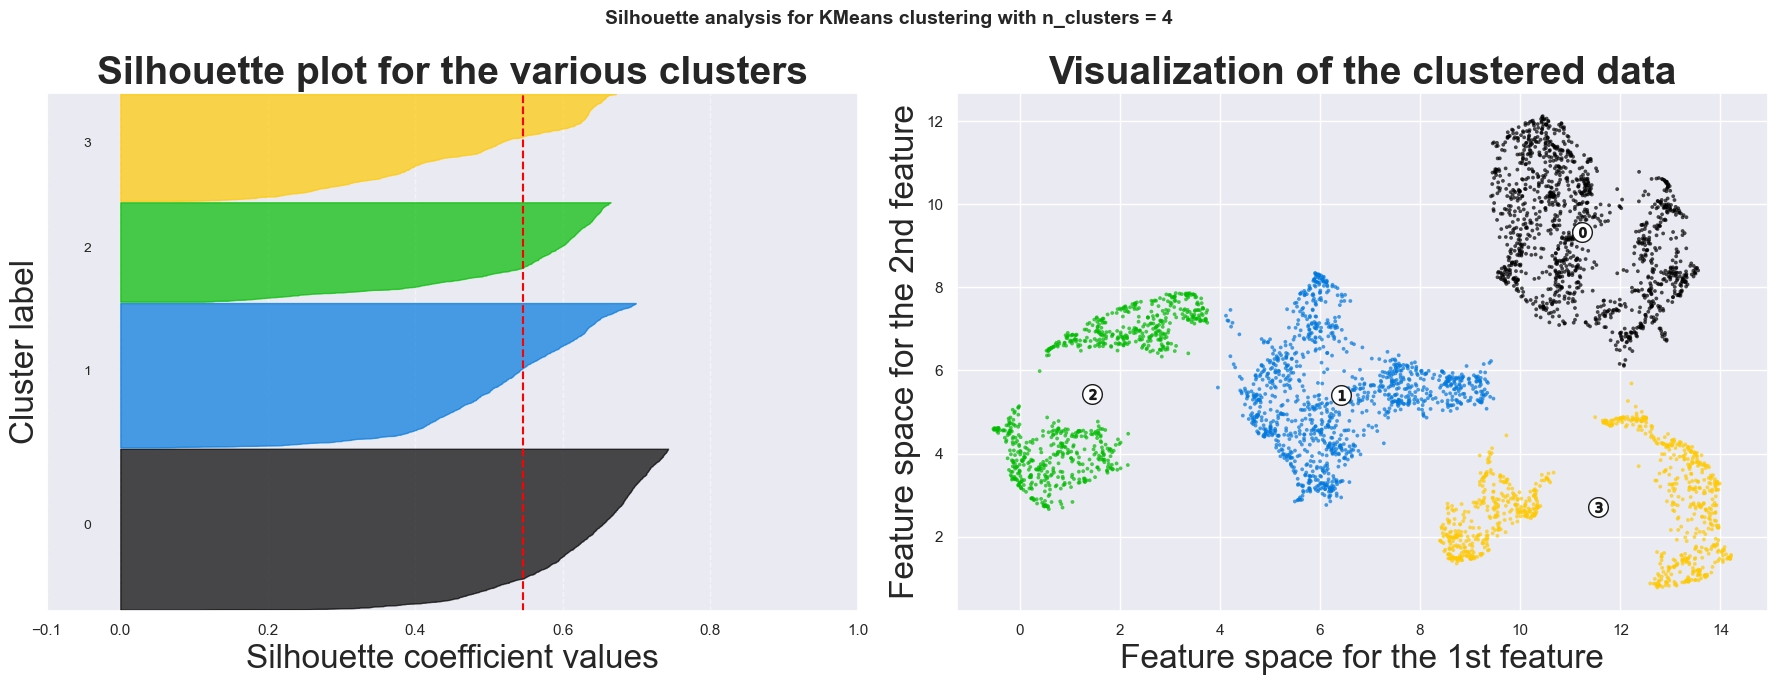

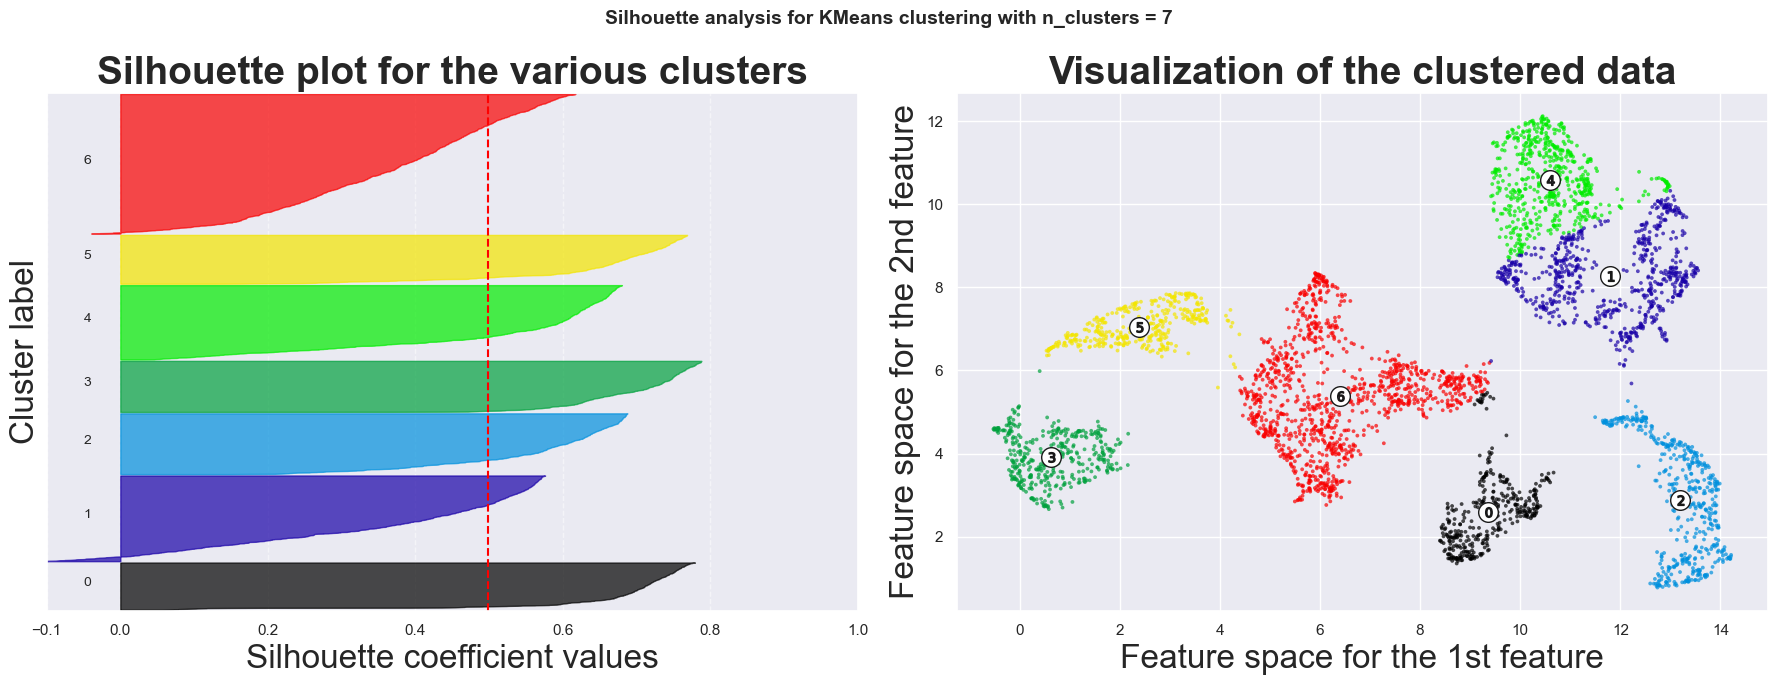

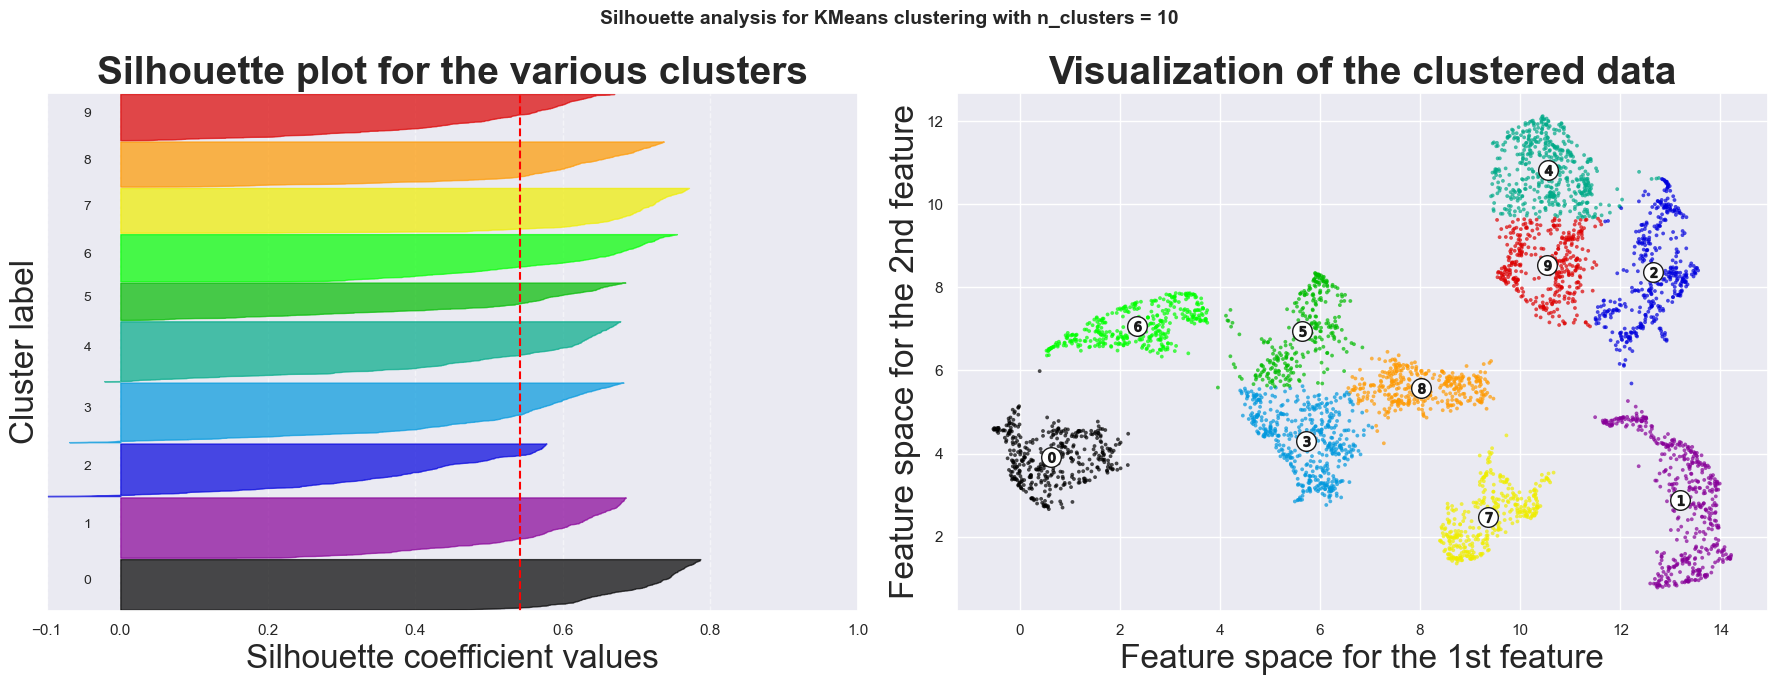

In [173]:
range_n_clusters = [4, 7, 10]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_umap) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_umap)

    silhouette_avg = silhouette_score(X_umap, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_umap, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
             0,
             ith_cluster_silhouette_values,
             facecolor=color,
             edgecolor=color,
             alpha=0.7,
         )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontdict={'fontsize': 10})

        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for the various clusters", fontweight="bold")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.grid(True, linestyle="--", alpha=0.5)

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_umap[:, 0], X_umap[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of the clustered data", fontweight="bold")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

    plt.tight_layout()
    plt.show()

In [133]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap)
    silhouette_avg = silhouette_score(X_umap, labels)
    print(f"Silhouette score for k={k}: {silhouette_avg}")

Silhouette score for k=4: 0.545521080493927
Silhouette score for k=7: 0.4993641972541809
Silhouette score for k=10: 0.5411916375160217


The results indicates better clustering results, with well-separated and distinct clusters.

- **Silhouette score for k=4: 0.545** indicates that the clusters were relatively well-separated and distinct from each other.

- **Silhouette score for k=7: 0.499** is lower than the previous one, suggesting that the clusters might be less well-defined or overlapping to some extent.

- **Silhouette score for k=10: 0.541** is similar to the score for k=4, indicating that the clusters are relatively well-separated and distinct from each other.

In [147]:
k_values = range(2, 11)

inertias = []
silhouette_avg = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap)
    silhouette_avg.append(silhouette_score(X_umap, labels))
    inertias.append(kmeans.inertia_)

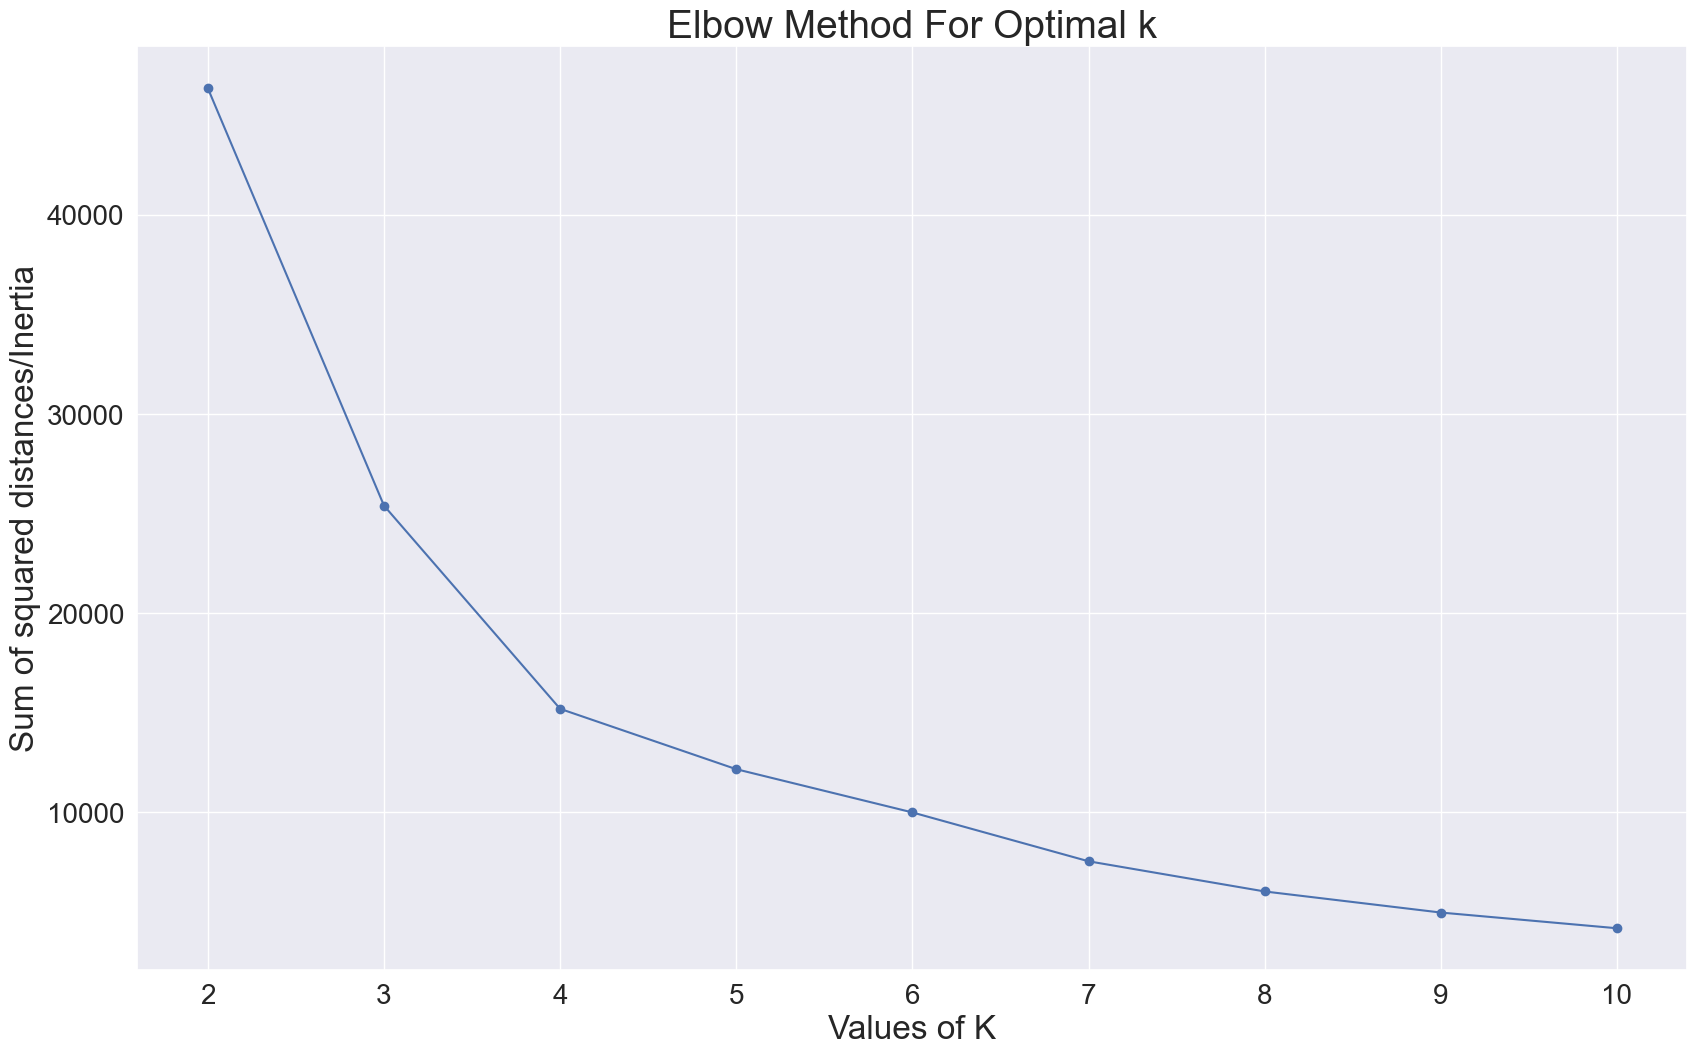

In [157]:
plt.plot(np.arange(len(k_values)), inertias, marker='o')
plt.xticks(np.arange(len(k_values)), k_values, fontsize=20) 
plt.yticks(fontsize=20)
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow method determines the optimal number of clusters by evaluating the distortion or inertia within each cluster. It looks for the point of inflection in the plot of the distortion/inertia versus the number of clusters. In this case, the elbow point is at k=4, indicating that adding more clusters does not significantly reduce the distortion.

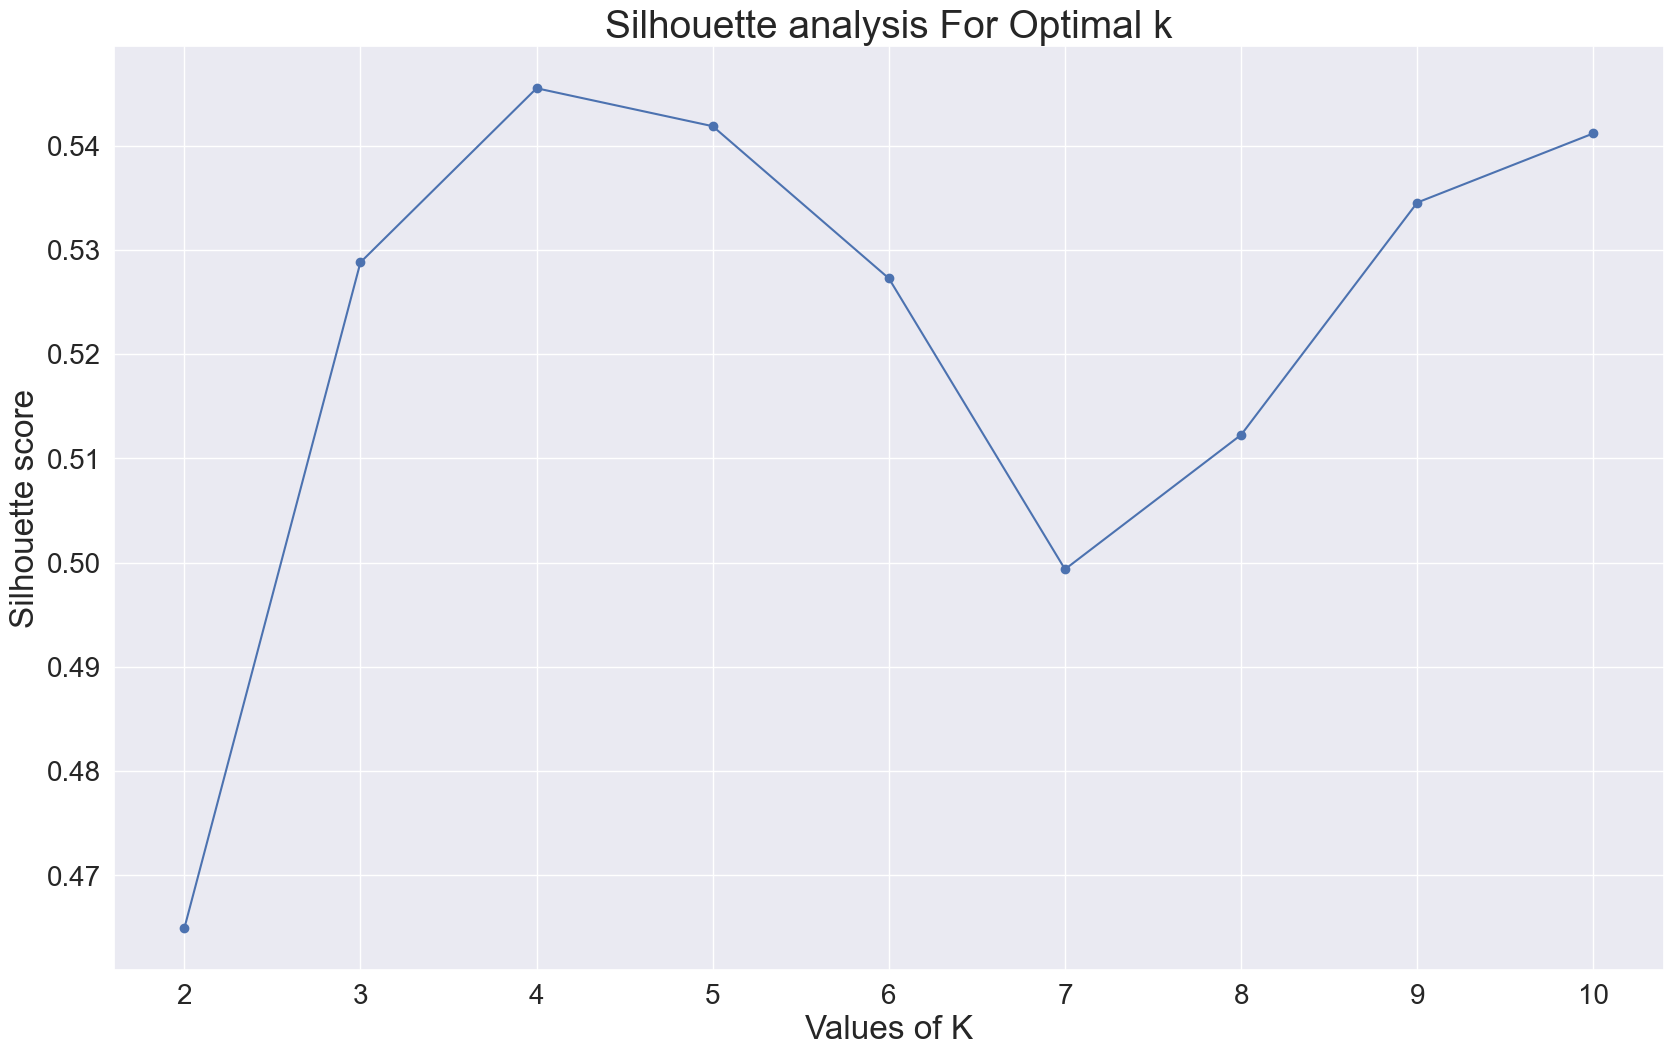

In [156]:
plt.plot(np.arange(len(k_values)), silhouette_avg, marker='o')
plt.xticks(np.arange(len(k_values)), k_values, fontsize=20) 
plt.yticks(fontsize=20)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

The silhouette score measures the average distance between samples in one cluster compared to samples in neighboring clusters. Higher silhouette scores indicate better-defined and well-separated clusters. In this case, the silhouette score is highest for k=4, suggesting that the data is most suitable for four distinct clusters.

Based on the results obtained from the elbow method and the silhouette score, it seems that the optimal number of clusters for the given data is k=4.

### Classification using lower dimensions
Next, let's train a Logistic Regression classifier on the original data and on data of reduced dimensions.  

Let's start with a classifier on the original MNIST dimensions.

#### Original data

In [181]:
model_origin = LogisticRegression().fit(X_train, y_train)

In [184]:
print("Classification report original train data:")
print(metrics.classification_report(y_train, model_origin.predict(X_train)))

Classification report original train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       1.00      1.00      1.00       458
           2       1.00      1.00      1.00       382
           3       1.00      1.00      1.00       392
           4       1.00      1.00      1.00       388
           5       1.00      1.00      1.00       354
           6       1.00      1.00      1.00       377
           7       1.00      1.00      1.00       429
           8       1.00      1.00      1.00       410
           9       1.00      1.00      1.00       419

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [185]:
print("Classification report original test data:")
print(metrics.classification_report(y_test, model_origin.predict(X_test)))

Classification report original test data:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       110
           1       0.91      0.97      0.94       115
           2       0.85      0.82      0.84       112
           3       0.83      0.83      0.83       102
           4       0.80      0.87      0.84        87
           5       0.79      0.77      0.78        70
           6       0.96      0.89      0.92        95
           7       0.91      0.84      0.87       120
           8       0.81      0.78      0.79        94
           9       0.79      0.83      0.81        95

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



The classification reports provide evaluation metrics such as precision, recall, and F1-score for different classification algorithms applied to various datasets. Here are the conclusions we can draw from the given reports:

**1. Original Train Data:**
   - All classes have perfect precision, recall, and F1-scores, indicating a highly accurate classification model.
   - The model achieves 100% accuracy on the training data, suggesting that it has learned the patterns and features well.

**2. Original Test Data:**
   - The model achieves good overall performance on the test data, with an accuracy of 86%.
   - Precision, recall, and F1-scores vary across different classes, indicating variations in classification performance for different digits.
   - Some classes, like 0, 1, and 7, have high precision and recall, while others, like 4 and 5, have slightly lower scores.

Now build a classifier on the projection made by PCA to 50 dimensions.

#### PCA 50D

In [188]:
model_pca = LogisticRegression().fit(X_pca, y_train)

In [189]:
print("Classification report PCA train data:")
print(metrics.classification_report(y_train, model_pca.predict(X_pca)))

Classification report PCA train data:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       391
           1       0.94      0.97      0.96       458
           2       0.92      0.88      0.90       382
           3       0.89      0.88      0.88       392
           4       0.92      0.95      0.93       388
           5       0.86      0.85      0.86       354
           6       0.95      0.97      0.96       377
           7       0.92      0.94      0.93       429
           8       0.90      0.83      0.87       410
           9       0.90      0.90      0.90       419

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



In [190]:
print("Classification report PCA train data:")
print(metrics.classification_report(y_test, model_pca.predict(pca.transform(X_test))))

Classification report PCA train data:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       110
           1       0.88      0.99      0.93       115
           2       0.96      0.84      0.90       112
           3       0.89      0.78      0.83       102
           4       0.83      0.84      0.83        87
           5       0.79      0.81      0.80        70
           6       0.96      0.93      0.94        95
           7       0.91      0.92      0.91       120
           8       0.85      0.85      0.85        94
           9       0.78      0.85      0.81        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



**1. PCA Train Data:**
   - The performance of the model trained on PCA-transformed data is slightly lower compared to the original data.
   - Although accuracy remains high at 92%, some minor decreases in precision, recall, and F1-scores can be observed for certain classes.

**2. PCA Test Data:**
   - Similar to the train data, the model's performance on the PCA-transformed test data is slightly lower compared to the original test data.
   - While accuracy is still reasonable at 88%, there are decreases in precision, recall, and F1-scores for certain classes.

Next build a classifier on the projection made by using UMAP to reduce the dimensions of the original data to 50 dimensions.

#### UMAP 50D

In [198]:
umap_50d = umap.UMAP(n_components=50)
X_umap = umap_50d.fit_transform(X_train)
model_umap_50D = LogisticRegression().fit(X_umap, y_train)

In [201]:
print("Classification report UMAP 50D train data:")
print(metrics.classification_report(y_train, model_umap_50D.predict(X_umap)))

Classification report UMAP 50D train data:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       391
           1       0.89      0.99      0.94       458
           2       0.98      0.88      0.93       382
           3       0.86      0.89      0.87       392
           4       0.93      0.92      0.92       388
           5       0.89      0.87      0.88       354
           6       0.97      0.97      0.97       377
           7       0.92      0.93      0.93       429
           8       0.96      0.83      0.89       410
           9       0.87      0.90      0.89       419

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



In [202]:
print("Classification report UMAP 50D test data:")
print(metrics.classification_report(y_test, model_umap_50D.predict(umap_50d.transform(X_test))))

Classification report UMAP 50D test data:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       110
           1       0.82      1.00      0.90       115
           2       0.99      0.84      0.91       112
           3       0.85      0.83      0.84       102
           4       0.86      0.86      0.86        87
           5       0.85      0.80      0.82        70
           6       0.94      0.97      0.95        95
           7       0.92      0.90      0.91       120
           8       0.93      0.80      0.86        94
           9       0.83      0.91      0.86        95

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



**1. UMAP 50D Train Data:**
   - The UMAP-transformed data produces similar performance to the original data, with an accuracy of 92% on the training set.
   - Precision, recall, and F1-scores are generally high across all classes, indicating robust classification.

**2. UMAP 50D Test Data:**
   - The UMAP-transformed test data achieves a reasonable accuracy of 89%.
   - Performance metrics show good precision, recall, and F1-scores for most classes, though some classes have lower scores.

Finally, let's build a classifier on the projection made by using UMAP to reduce the dimensions of the original data to **2** dimensions.

#### UMAP 2D

In [207]:
umap_2d = umap.UMAP(n_components=2)
X_umap = umap_2d.fit_transform(X_train)
model_umap_2D = LogisticRegression().fit(X_umap, y_train)

In [208]:
print("Classification report UMAP 2D train data:")
print(metrics.classification_report(y_train, model_umap_2D.predict(X_umap)))

Classification report UMAP 2D train data:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       391
           1       0.88      0.99      0.93       458
           2       0.98      0.88      0.92       382
           3       0.84      0.89      0.86       392
           4       0.80      0.79      0.79       388
           5       0.89      0.85      0.87       354
           6       0.96      0.96      0.96       377
           7       0.92      0.91      0.92       429
           8       0.94      0.83      0.88       410
           9       0.77      0.81      0.79       419

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



In [209]:
print("Classification report UMAP 2D test data:")
print(metrics.classification_report(y_test, model_umap_2D.predict(umap_2d.transform(X_test))))

Classification report UMAP 2D test data:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       110
           1       0.82      1.00      0.90       115
           2       0.99      0.82      0.90       112
           3       0.85      0.82      0.84       102
           4       0.84      0.74      0.79        87
           5       0.84      0.83      0.83        70
           6       0.95      0.96      0.95        95
           7       0.91      0.92      0.91       120
           8       0.86      0.79      0.82        94
           9       0.72      0.83      0.77        95

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000



**1. UMAP 2D Train Data:**
   - The UMAP 2D-transformed data leads to slightly lower performance compared to the original data, with an accuracy of 89% on the training set.
   - Precision, recall, and F1-scores remain high, but some decrease is observed for certain classes.

**2. UMAP 2D Test Data:**
   - Similar to the train data, the UMAP 2D-transformed test data exhibits slightly lower performance compared to the original test data.
   - While accuracy is reasonable at 87%, some classes have lower precision, recall, and F1-scores.

#### HDBSCAN

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that can automatically discover clusters of varying densities in data. Here, it is applied to the UMAP embeddings umap_embedding to assign cluster labels.

In [227]:
umap_obj = umap.UMAP(random_state=0, n_components=10, n_neighbors=30)
train_umap_embedding = umap_obj.fit_transform(X_train)
test_umap_embedding = umap_obj.transform(X_test)

labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(umap_embedding)

transformed_X_train = [np.concatenate((vec_embedding, [label])) for vec_embedding, label in zip(train_umap_embedding, labels)]
transformed_X_test = [np.concatenate((vec_embedding, [label])) for vec_embedding, label in zip(test_umap_embedding, labels)]
model_HDBSCAN = LogisticRegression().fit(transformed_X_train, y_train)

In [228]:
print("Classification report HDBSCAN test data:")
print(metrics.classification_report(y_train, model_HDBSCAN.predict(transformed_X_train)))

Classification report HDBSCAN test data:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       391
           1       0.87      0.99      0.93       458
           2       0.98      0.88      0.93       382
           3       0.84      0.89      0.86       392
           4       0.92      0.91      0.91       388
           5       0.89      0.84      0.86       354
           6       0.96      0.97      0.96       377
           7       0.93      0.92      0.92       429
           8       0.95      0.84      0.89       410
           9       0.86      0.90      0.88       419

    accuracy                           0.91      4000
   macro avg       0.92      0.91      0.91      4000
weighted avg       0.92      0.91      0.91      4000



In [229]:
print("Classification report HDBSCAN test data:")
print(metrics.classification_report(y_test, model_HDBSCAN.predict(transformed_X_test)))

Classification report HDBSCAN test data:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       110
           1       0.79      0.93      0.86       115
           2       0.80      0.79      0.80       112
           3       0.83      0.77      0.80       102
           4       0.83      0.86      0.85        87
           5       0.51      0.77      0.61        70
           6       0.99      0.85      0.92        95
           7       0.90      0.88      0.89       120
           8       0.44      0.67      0.53        94
           9       0.75      0.35      0.47        95

    accuracy                           0.76      1000
   macro avg       0.78      0.75      0.75      1000
weighted avg       0.79      0.76      0.76      1000



**HDBSCAN Train and Test Data:**
- The accuracy on the training set is 0.91 (or 91%), which is slightly lower than the UMAP and original data.
- The accuracy on the test set is 0.76 (or 76%), indicating a lower performance compared to the UMAP and original test data.
- It's important to note that HDBSCAN is primarily a clustering algorithm and may not be optimized for classification tasks.

In conclusion, the original data achieved excellent performance on both the training and test sets. Applying dimensionality reduction techniques like PCA and UMAP generally maintained good performance, with UMAP achieving better accuracy. However, using HDBSCAN, which is primarily a clustering algorithm, resulted in decreased performance on the test data compared to other approaches.

### Using UMAP for classification

UMAP has a special mode of operation, that learns the transformation **given the true labels**.  
To run it, add the true labels to the fit function.

We can simply pass the UMAP model that target data when fitting and it will make use of it to perform supervised dimension reduction.

In [113]:
umap_obj = umap.UMAP()
umap_embedding = umap_obj.fit_transform(X_train, y=y_train)

As before we have reduced the data down to two dimensions so we can again visualize the data with a scatterplot, coloring by class.

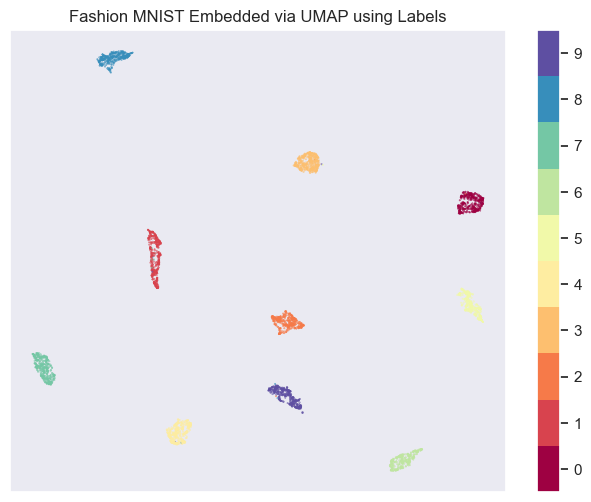

In [114]:
fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*umap_embedding.T, s=0.1, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
plt.title('Fashion MNIST Embedded via UMAP using Labels');

The result is a cleanly separated set of classes. The first point to note is that we have retained the internal structure of the individual classes. Both the numbers 4 and 9 still have the distinct banding pattern that was visible in the original unsupervised case. The second point to note is that we have also retained the global structure.

In [115]:
model_umap_embedding = LogisticRegression().fit(umap_embedding, y_train)

In [116]:
print("Classification report for UMAP embedding 50D train data:")
print(metrics.classification_report(y_train, model_umap_embedding.predict(umap_embedding)))

Classification report for UMAP embedding 50D train data:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       397
           1       0.98      1.00      0.99       451
           2       1.00      0.99      0.99       409
           3       0.99      0.99      0.99       438
           4       0.99      1.00      1.00       386
           5       1.00      0.99      1.00       356
           6       1.00      1.00      1.00       366
           7       1.00      0.99      0.99       428
           8       0.99      0.99      0.99       392
           9       0.99      0.99      0.99       377

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



In [117]:
print("Classification report for UMAP embedding 50D test data:")
print(metrics.classification_report(y_test, model_umap_embedding.predict(umap_obj.transform(X_test))))

Classification report for UMAP embedding 50D test data:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        94
           1       0.83      0.99      0.91       117
           2       0.93      0.85      0.89       105
           3       0.78      0.91      0.84        98
           4       0.90      0.94      0.92       102
           5       0.91      0.85      0.88        88
           6       0.97      0.98      0.97        93
           7       0.96      0.90      0.93       105
           8       0.96      0.73      0.83       101
           9       0.90      0.87      0.88        97

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000

